# Power Sector Asset Networks - Describing Energy Transitions


*Lucas Kruitwagen & Maria del Rio Chanona*

## Introduction

<div style="text-align: justify"> 
The simultaneous expansion and decarbonisation of the global power sector is imperative for achieving the mutually dependent goals of poverty alleviation and the mitigation of climate change. Substantial policy and cost reductions in renewable generating options over the period of 2007 to 2017 were met with a three-fold increase in global renewable generating capacity. If sufficient renewable generating capacity is to be deployed to meet sustainable development imperatives, early evidence of the dynamics thereof might be captured in this period.</div><br>
</br>
<div style="text-align: justify"> Asset-level data sets of the global power sector have been obtained from S&amp;P Market Intelligence for the years 2007 through 2017. Power sector companies and generating assets are arranged into a bipartite network. This notebook describes the data and basic network properties; develops a fitness criterion and tests *preferential attachment* as a mechanism for edge formation in a null model; clusters similar companies and presents transitions in clusters; and speculates how a synthetic model might use company clusters to describe energy transitons subject to network, peer, and exogenous affects. </div>

## Contents

- [Data Description](#2.-Data-Description)
- [Network Arrangement](#3.-Asset-Company-Network-Arrangement)
- [Basic Network Properties](#4.-Basic-Network-Properties)
    - [Asset size and fuel class distributions](#4.1-Generating-Asset-Size-and-Fuel-Class-Distributions)
    - [Asset Retirements](#4.2-Asset-Retirements)
    - [Company Mergers, Acquisitions, Splits](#4.3-Company-Mergers,-Acquisition,-and-Splits)
    - [HHI](#4.4-Market-HHI)
    - [Degree Distributions of companies](#4.5-Degree-Distributions)
- [Null model: edge formation via preferential attachment](#5.-Null-Model---Preferential-Attachment)
- [Company Clusters and Transitions](#6.-Company-Clusters-and-Transitions)
- [Towards a synthetic model](#7.-Towards-a-Synthetic-Model)

In [2]:
## Getting started - Load some libraries

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
import networkx as nx
import random, math, glob, os, pickle, time, copy, ternary
import pandas as pd
import statsmodels.api as sm
import scipy.stats as s
import numpy as np
from PIL import Image
from helpers import *
from sklearn import linear_model
from sklearn.cluster import KMeans
from scipy.optimize import minimize, curve_fit
from scipy.misc import factorial
from collections import OrderedDict
import warnings; warnings.simplefilter('ignore')

# Most custom code in utils
from utils import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 2. Data Description

<div style="text-align: justify"> Asset-level data for the global power sector have been obtained from S&P Market Intelligence's World Electric Power Plant database (WEPP) for the years 2007 through 2017 inclusive. WEPP is a feature-rich database of power generating units, their fuel inputs and technical parameters, their locations, and their corporate owners. WEPP's authors claim complete coverage (>95%) for almost all fuel and conversion technologies over 50MW in size, comprehensive (>75%) coverage for smaller generating units or select conversions and geographies, particularly China, and less than comprehensive coverage (<75%) for only a few niche technologies or geographies (S&P REF). Fuel classes have been aggregated into three characteristic categories, fossil fuels, low-carbon, and renewables, according to Table REF. Hydro Power has been included in the ‘low carbon’ fuel class because the power stations are typically large, fixed capital assets, and in many countries in the world the economic hydropower resources have been fully realised (REF).</div><br>


<div style="text-align: center"> **Table: Fuel Class Consolidation**</div>

| Study Fuel Class | Alias | WEPP Fuel Classes |
| - 
| Renewables | 'green' | AGAS;  BAG;  BGAS;  BIOMASS;  BL; DGAS; ETHANOL; GEO; H2; HELIUM;  LIGNIN; LIQ; MANURE; MBM; MEDWST; METHANOL; PEAT; PWST; SUN; WIND; WOOD; WOODGAS; |
| Low-Carbon | 'blue'  | WAT; UR|
| Fossil Fuels | 'ff'  | BFG; BITUMEN; CGAS; CKGAS; COAL; COG; COKE; CSGAS; CWM; CXGAS; DME; FGAS; GAS; JET; KERO; LNG; LPG; MGAS; NAP; NGL; OGAS; OIL; ORI; RGAS; SHALE; TGAS; TSAND; UNK; VOCGAS; HZDWST; INDWST; LGAS; REF; REFGAS; RPF; TIRES; WSTGAS; WSTH; WSTWSL |

<div style="text-align: justify"> Only operating units are included in the dataframes for analysis. Dataframes are complete with commissioning year, generating capacity in MW, study fuel class, and corporate owner for each unit. Where commissioning years are not available, they are interpolated using an ordinary least squares regression with WEPP fuel class, operating status, region, and heat rate as independent variables. Units are aggregated up to the plant level, summing generating capacity and averaging commissioning years weighted by generating capacity.</div><br>

In [3]:
## Load and clean the data

wepps = [
    'WEPP_FILES/2007-Q4-DEC', 'WEPP_FILES/2008-Q4-DEC', 'WEPP_FILES/2009-Q4-DEC', 'WEPP_FILES/2010-Q4-DEC',
    'WEPP_FILES/2011-Q3-SEP', 'WEPP_FILES/2012-Q4-DEC', 'WEPP_FILES/2013-Q4-DEC', 'WEPP_FILES/2014-q4-dec',
    #'WEPP_FILES/2015-Q1-MAR',
    #'WEPP_FILES/2015-Q2-JUN',
    #'WEPP_FILES/2015-q3-sep',
    'WEPP_FILES/2015-Q4-DEC',
    #'WEPP_FILES/2016-Q1-APR',
    #'WEPP_FILES/2016-Q2-JUL',
    #'WEPP_FILES/2016-Q3-SEP',
    'WEPP_FILES/2016-Q4-DEC',
    #'WEPP_FILES/2017-Q1-MAR',
    #'WEPP_FILES/2017-Q2-JUL',
    #'WEPP_FILES/2017-Q3-SEP',
    'WEPP_FILES/2017-Q4-DEC']

years = range(2007,2018)

wepps_dict = dict(zip(years,wepps))

wepp_dfs = {}

for y in years:
    wepp_dfs[y] = get_wepp(wepps_dict[y])
    wepp_dfs[y] = prep_wepp(wepp_dfs[y])
    wepp_dfs[y] = wepp_dfs[y][['UNIT','PLANT','COMPANY','MW','STATUS','YEAR','UNITID','fuel_class','ISO','CO2_INT','CCCE','green','green_MW','blue','blue_MW','solar', 'solar_MW', 'wind', 'wind_MW', 'ff', 'ff_MW']]
    wepp_dfs[y].STATUS = wepp_dfs[y].STATUS.str.upper()
    wepp_dfs[y].drop(wepp_dfs[y][wepp_dfs[y]['STATUS']!='OPR'].index, inplace=True)
    

## 3. Asset-Company Network Arrangement

<div style="text-align: justify">Bipartite networks are a common class of complex networks wherein two sets of nodes are connected by edges which may only form between two nodes of different sets. The relationship indicated by the presence of an edge is often intuitively defined by the definitions of the two node sets, such as _ relationship between _ and _ ; Bipartite networks can also be *projected* along one set of nodes, showing the relationships between a set of nodes by virtue of their intermediation by another set of nodes, see Fig REF. </div><br>
**Fig: Projection of a Bipartite Network**
<img src="files/bipartite.png">
<div style="text-align: justify">In this study, node sets of generating assets and companies are arranged into a bipartite network. Edges are defined by the ownership of generating assets by companies. The example shown in Fig REF shows the asset projection of the bipartite network for a select country and year. Node size indicates generating capacity in MW, node color indicates fuel class.</div>

For country iso DK, in year 2017:


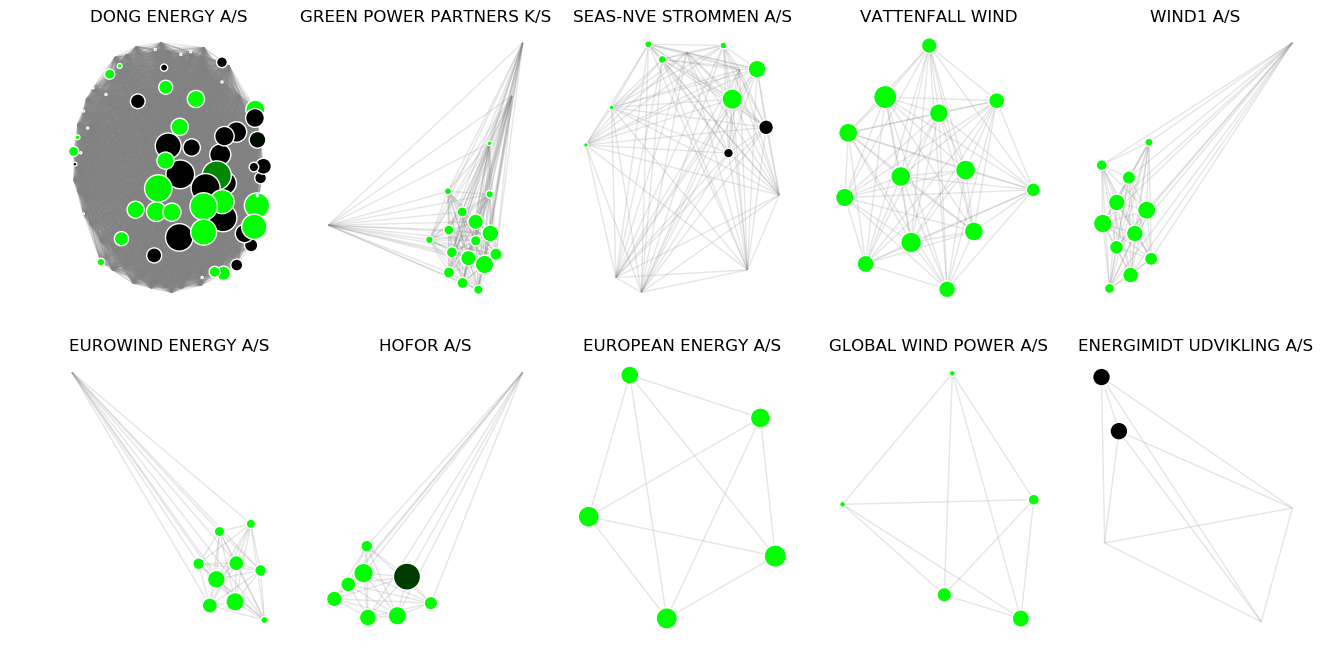

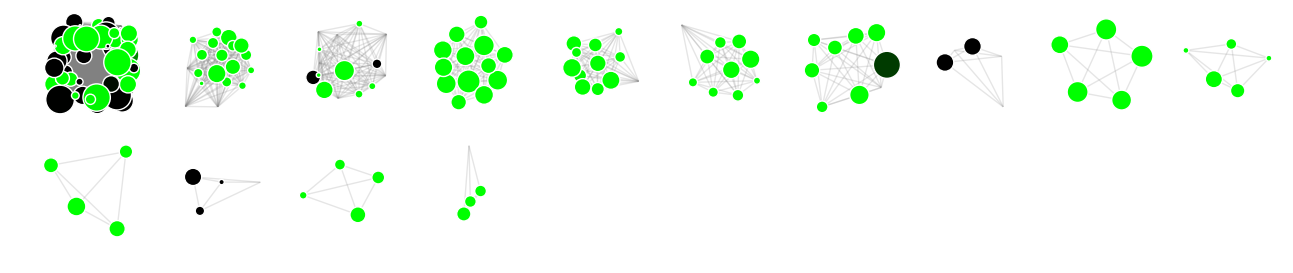

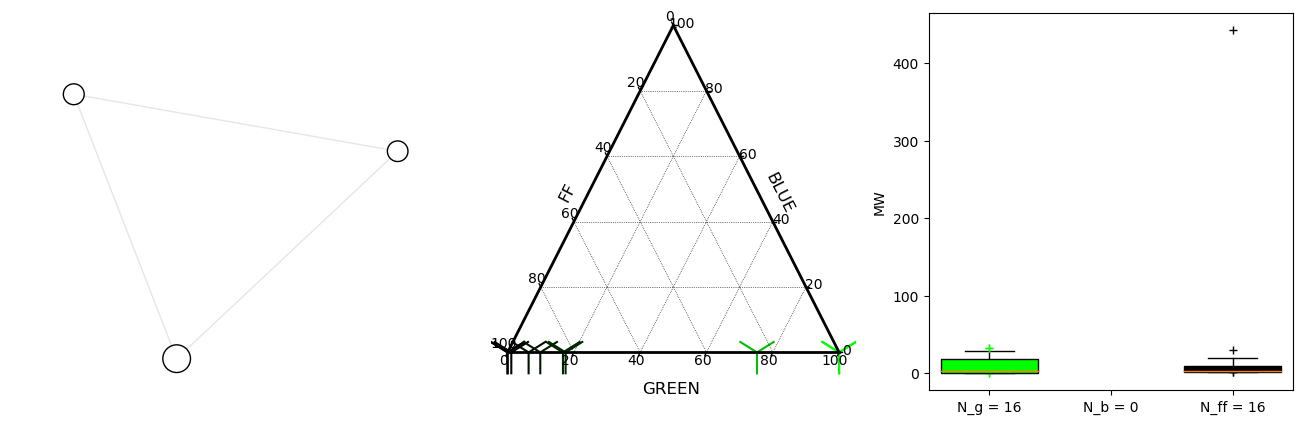

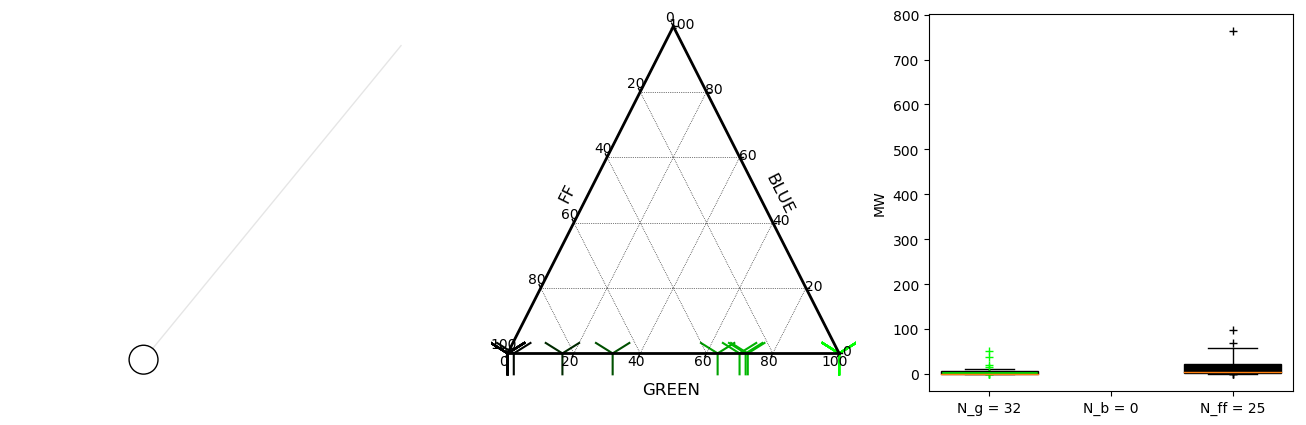

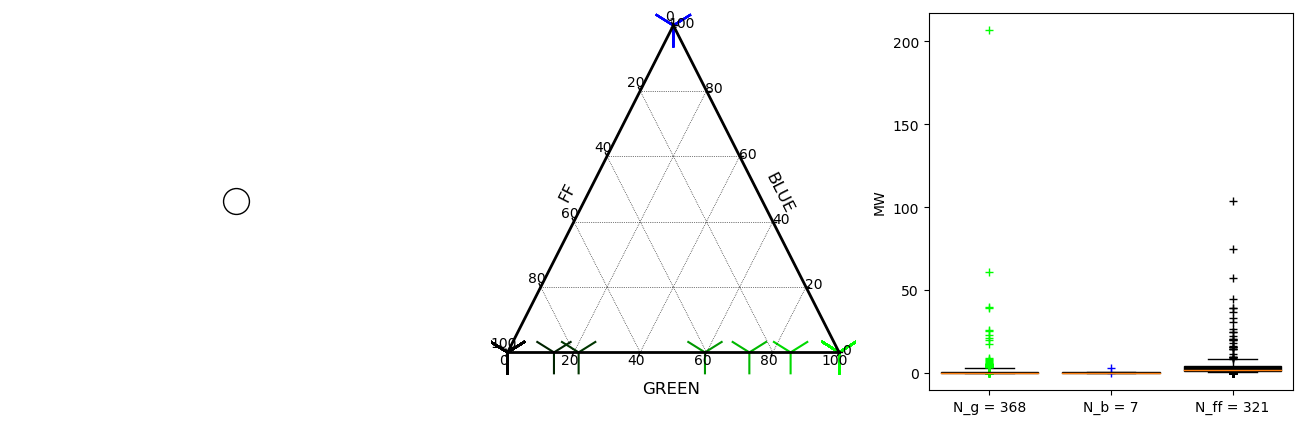

In [7]:
select_iso = 'DK'
select_year = 2017

iso_slice, iso_slice_plants, iso_slice_meta = {},{},{}
for y in years:
    iso_slice[y], iso_slice_plants[y], iso_slice_meta[y] = prep_iso_slices(wepp_dfs[y], select_iso)

print 'For country iso '+select_iso+', in year '+str(select_year)+':'   
draw_top_companies(iso_slice_plants[select_year], MW=False, N=10)
draw_all_components(iso_slice_plants[select_year], MW=False, N_GT=3)
draw_IADS(iso_slice_plants[select_year], N_iad = 3)
draw_IADS(iso_slice_plants[select_year], N_iad = 2)
draw_IADS(iso_slice_plants[select_year], N_iad = 1)

## 4. Basic Network Properties

<div style="text-align: justify">Some basic properties of the power sectors of different countries are compared in this section. </div>

In [4]:
## get the top N countries by generating capacity per year, combine the sets

N_top = 5
top_isos = set()
for y in years:
    top_isos = top_isos.union(set(wepp_dfs[y].groupby('ISO').sum().sort_values('MW', ascending=False).head(5).index.values))
top_isos = list(top_isos)
iso_colors = dict(zip(top_isos, ["#{0:02x}{1:02x}{2:02x}".format(clamp(int(np.random.rand()*255.)), clamp(int(np.random.rand()*255.)), clamp(int(np.random.rand()*255.))) for _ in top_isos]))

In [5]:
## ... or just choose your favourites
top_isos = ['GB','FR','RU','CN','IN']
iso_colors = dict(zip(top_isos, ["#{0:02x}{1:02x}{2:02x}".format(clamp(int(np.random.rand()*255.)), clamp(int(np.random.rand()*255.)), clamp(int(np.random.rand()*255.))) for _ in top_isos]))

### 4.1 Generating Asset Size and Fuel Class Distributions

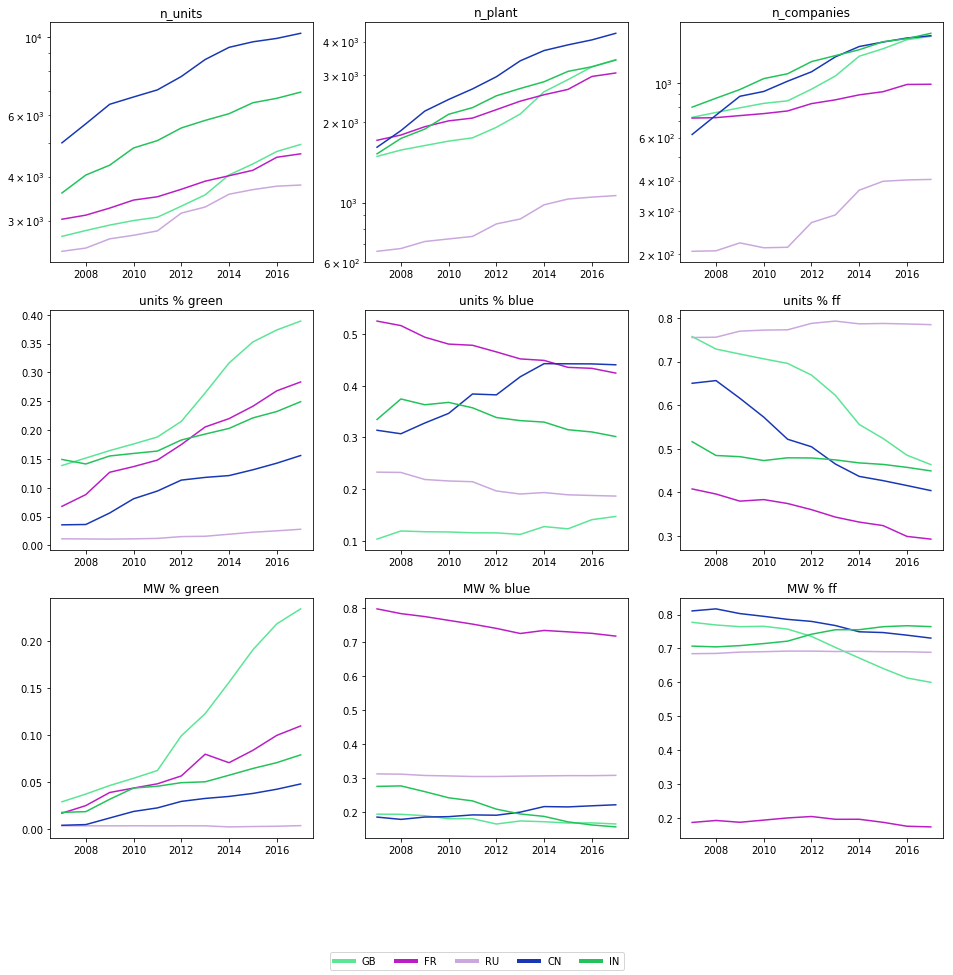

In [6]:
draw_basics(top_isos, wepp_dfs, years, iso_colors)

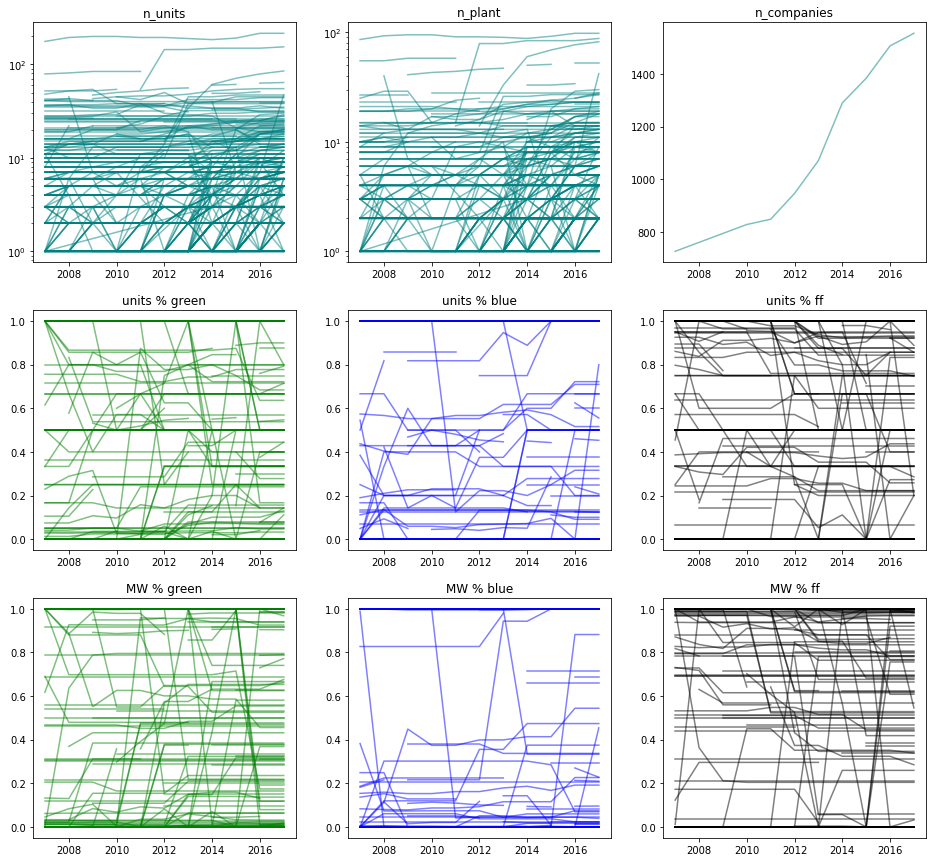

In [7]:
draw_basics_iso(iso_slice,years)
## By company

### 4.2 Asset Retirements & Births

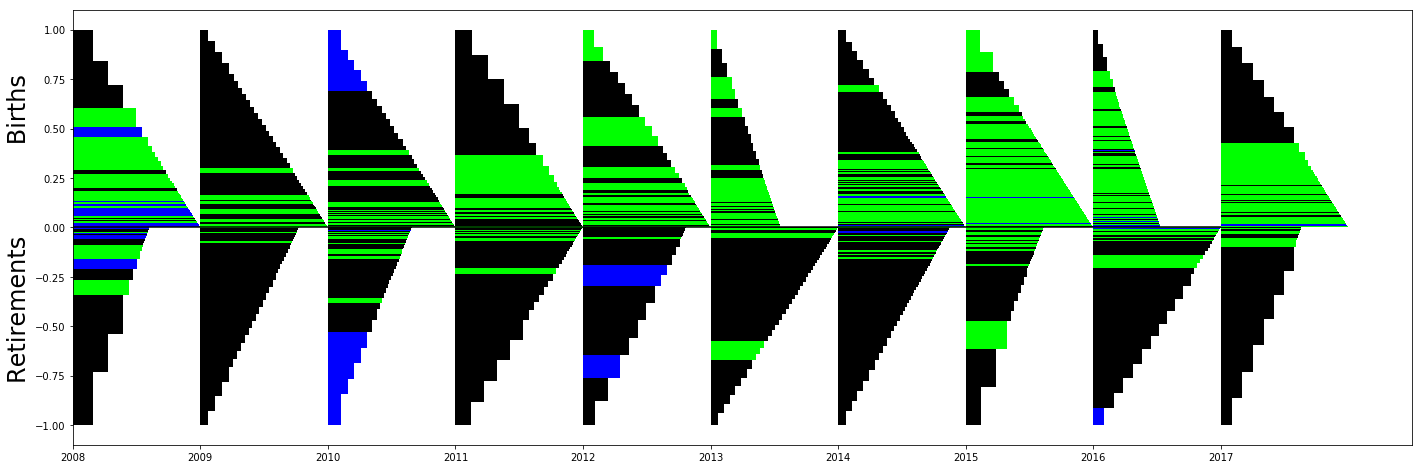

In [76]:
draw_retirements_births(iso_slice, years)

In [29]:
def birth_companies(iso_slice, iso_slice_meta, years):


    birth_units = {}
    for y in years[1:]:
        units_t_y = iso_slice[y].UNIT.values
        units_t_ym1 = iso_slice[y-1].UNIT.values
        born_units = []
        
                
        for u in units_t_y:
            if u not in units_t_ym1:
                born_units.append(u)
        birth_units[y] = born_units
        
    for y in years[1:2]:
        print iso_slice_meta[y-1]
        print sorted(iso_slice[y-1].COMPANY.unique())
        #print iso_slice_meta[y-1]
        for u in birth_units[y]:
            ## get the company
            company = iso_slice[y][iso_slice[y].UNIT==u].COMPANY.values[0]
            g = iso_slice[y][iso_slice[y].UNIT==u].green_MW.values[0] / iso_slice[y][iso_slice[y].UNIT==u].MW.values[0]
            print 'unit', g, iso_slice[y][iso_slice[y].UNIT==u].MW.values[0]
            if company in iso_slice[y].COMPANY.values:

                print 'company',iso_slice_meta[y].loc[company].COUNT, iso_slice_meta[y].loc[company].MW, iso_slice_meta[y].loc[company].green_MW
            else:
                print 'no compnay'
        
    print birth_units

        
birth_companies(iso_slice,iso_slice_meta,years)

                                     MW  COUNT          CCCE  green_MW  \
COMPANY                                                                  
3C WASTE LTD                      0.875      1           NaN     0.000   
A PEARSON & SONS                  1.700      1  8.812118e+04     0.000   
ABB ZANTINGH LTD                 46.500      4  2.285881e+06     0.000   
ABBEY PRODUCE LTD                 0.225      1           NaN     0.225   
ABERGAVENNY LEISURE CENTRE        0.045      1  1.402089e+03     0.000   
ADVANTICA TECHNOLOGIES LTD        0.058      2  3.825126e+03     0.000   
AES (NI) LTD                    578.000      1  1.192748e+07     0.000   
AGRILEC LTD                       1.020      1           NaN     1.020   
AIRBUS                            4.200      3  2.381556e+05     0.000   
AIREDALE HOSPITAL                 0.320      1  1.077246e+04     0.000   
AIRTRICITY LTD                  115.500      3           NaN   115.500   
ALBREW MALSTERS                   0.75

unit 1.0 0.24
company 1.0 0.24 0.24
unit 0.0 5.6
company 21.0 73.658 34.448
unit 0.0 0.4
company 7.0 1.6830000000000003 1.175
unit 0.0 0.505
company 40.0 505.309 447.55
unit 0.0 0.42
company 3.0 0.74 0.0
unit 0.0 0.09
company 1.0 0.09 0.0
unit 0.0 0.075
company 15.0 9717.875000000002 4.2
unit 0.0 1.006
company 1.0 1.006 0.0
unit 0.0 9.2
company 40.0 505.309 447.55
unit 0.0 9.2
company 40.0 505.309 447.55
unit 0.0 10.0
company 40.0 505.309 447.55
unit 0.0 5.0
company 40.0 505.309 447.55
unit 0.0 1.5
company 11.0 9037.314 0.0
unit 0.0 1.5
company 11.0 9037.314 0.0
unit 0.0 0.4
company 1.0 0.4 0.0
unit 1.0 12.25
company 5.0 19.25 12.25
unit 1.0 35.0
company 5.0 178.0 178.0
unit 1.0 1.7
company 2.0 2.55 2.55
unit 0.0 1.56
company 55.0 111.212 14.45
unit 0.0 1.56
company 55.0 111.212 14.45
unit 0.0 0.15
company 3.0 0.74 0.0
unit 0.0 0.275
company 4.0 2.3000000000000003 2.025
unit 0.0 0.11
company 1.0 0.11 0.0
unit 0.0 0.4
company 1.0 0.4 0.0
unit 1.0 5.2
company 11.0 138.69 138.69
unit 1.0 

TBC

### 4.3 Company Mergers, Acquisitions, and Splits

TBC

### 4.4 Market HHI

TBC

### 4.5 Degree Distributions

<div style="text-align: justify">Degree distributions are a common network property which give insight into the mechanisms and relationships of interest in the network. Degree distributions are shown in Fig REF for the assets projection of the company-asset bipartite network, as in Fig REF above. Each company, then, is represented by a fully-connect component of asset nodes. The degree distribution is shown both in terms of number of nodes, and in terms of the sum of generating capacity in MW.</div>

GB


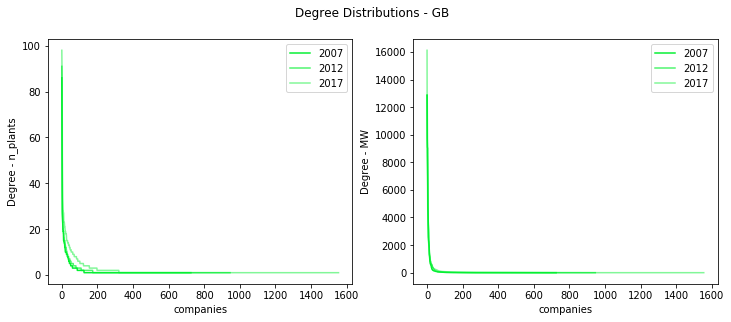

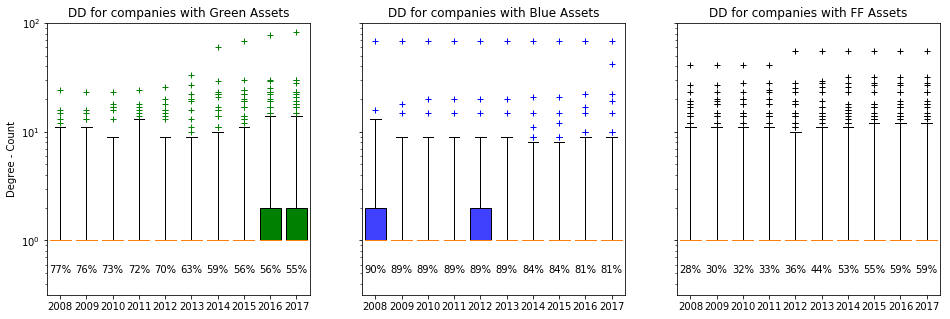

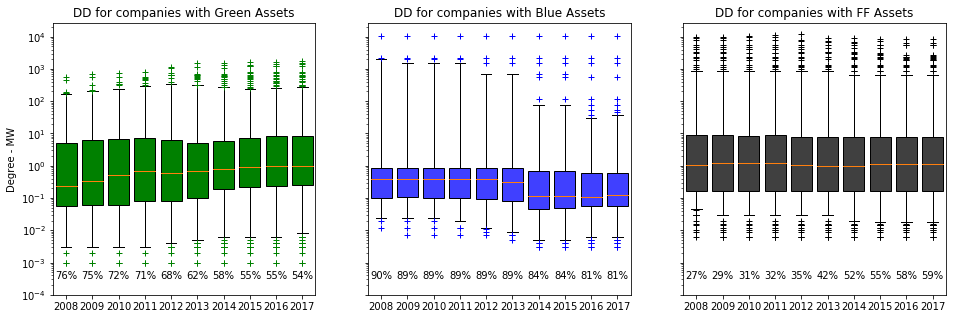

FR


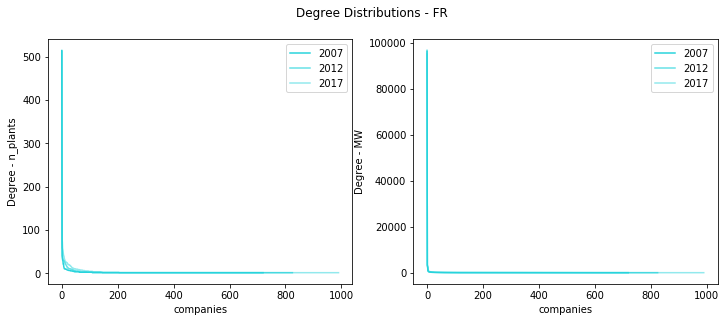

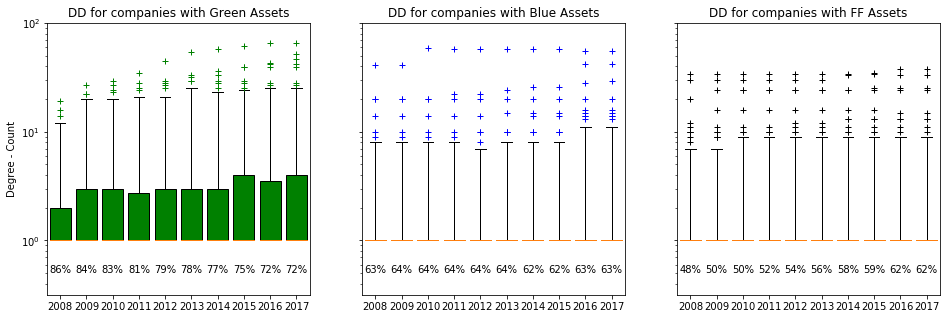

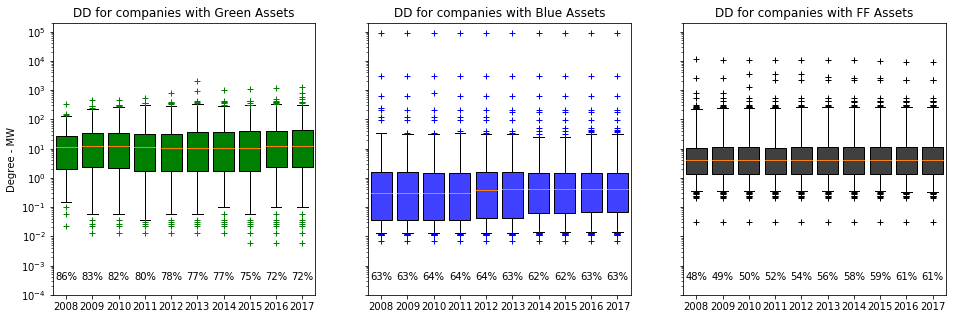

RU


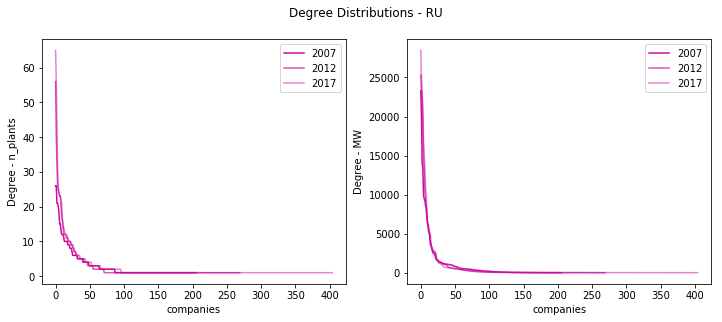

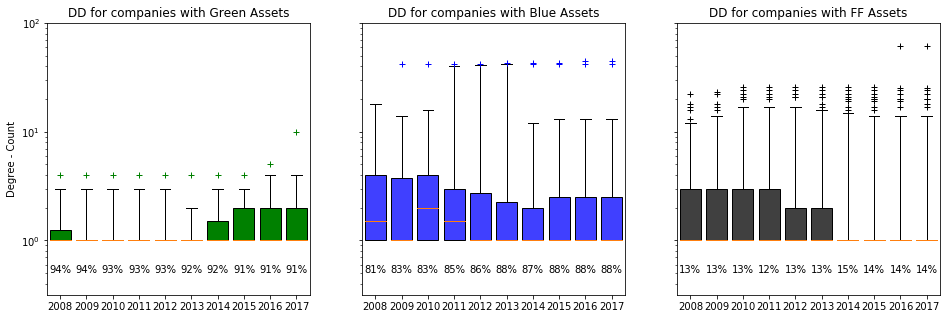

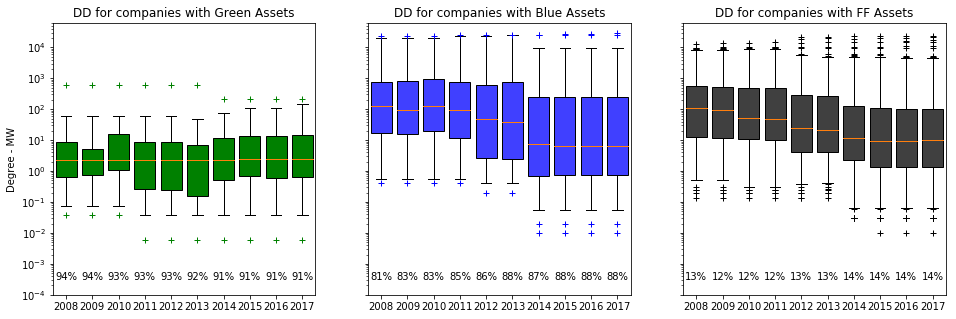

CN


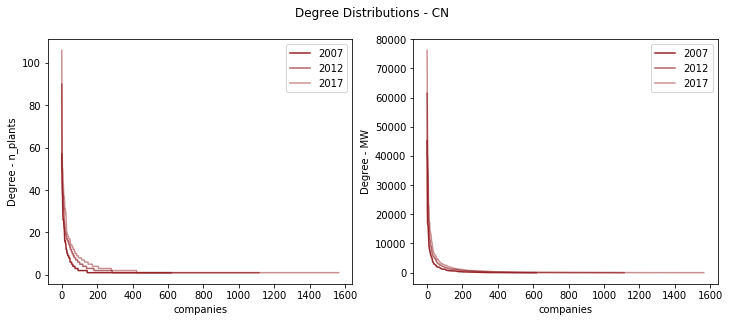

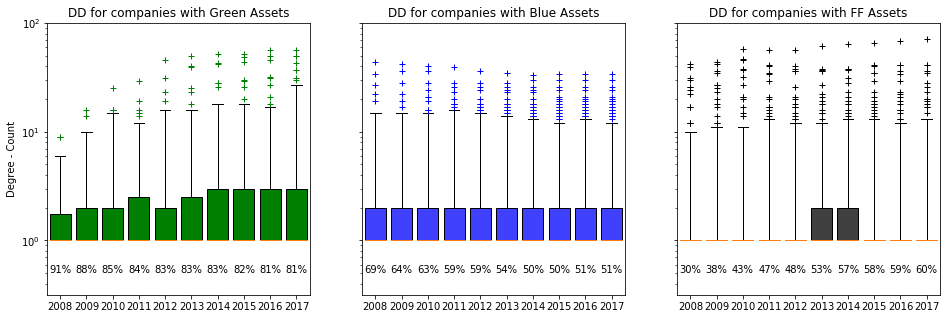

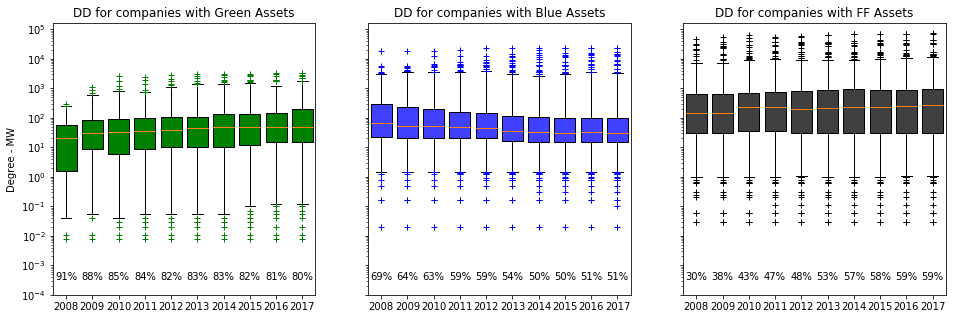

IN


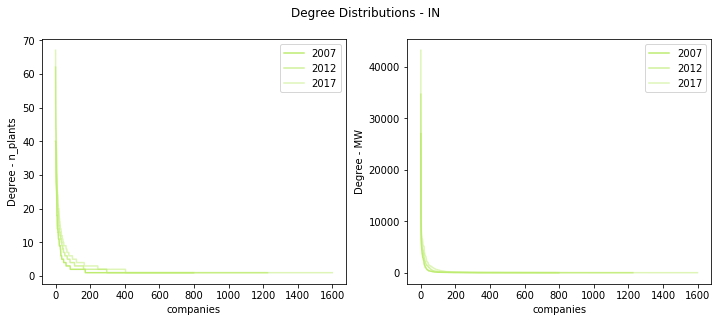

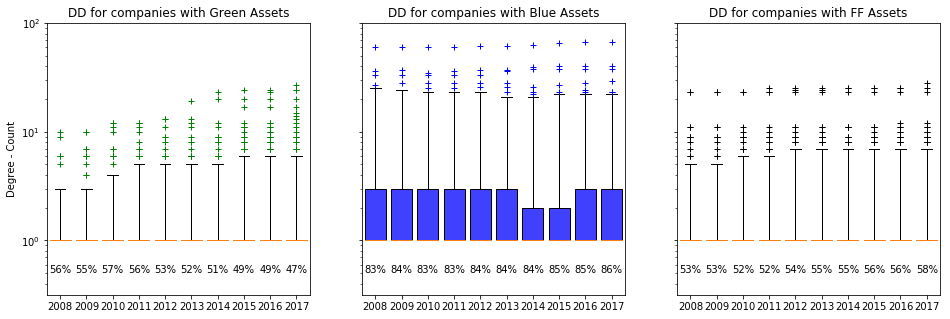

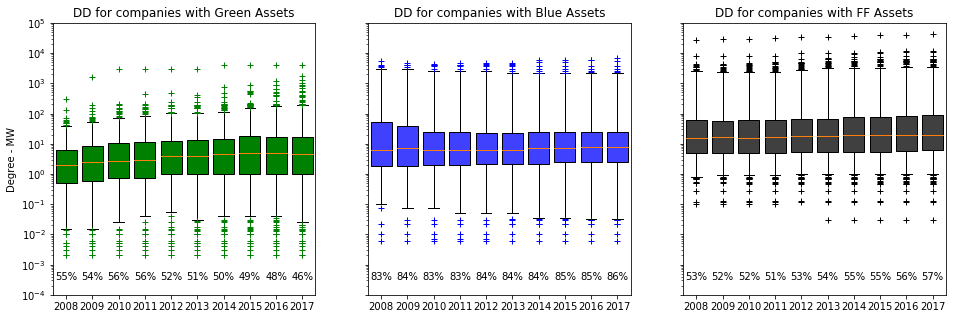

In [30]:
for iso in top_isos:
    print iso

    iso_slice, iso_slice_plants, iso_slice_meta = {},{},{}
    for y in years:
        iso_slice[y], iso_slice_plants[y], iso_slice_meta[y] = prep_iso_slices(wepp_dfs[y], iso)

    
    plot_DD_line(iso_slice_meta, iso, iso_colors[iso])
    plot_DD_boxplot(iso_slice_plants, 'true data', years, MW = False)
    plot_DD_boxplot(iso_slice_plants, 'true data', years, MW = True)
    print '*Percentages indicate the portion of companies _not_ possessing assets of the selected fuel class'

## 5. Null Model - Preferential Attachment

<div style="text-align: justify">The eventual goal of this work is to develop a model which describes, without priors drawn from the true data distributions, the evolution of power sectors asset networks and transitions occuring within them. The model should describe mechanisms which are informed by the innovation literature, allowing these mechanisms to be tested as an ensemble. Mechanisms should be generalised enough that the evolution of the power sector in any country can be described by the model. With power-law degree distributions as shown in Fig REF, a likely candidate for the edge formation mechanism of a growing network is *Preferential Attachment*. Preferential Attachment is tested in the null model described in this section. </div>

### 5.1 Preferential Attachment
<div style="text-align: justify">Among the comparator countries, company degree distributions tend to follow a power law. In network growth models, power law degree distributions indicate that there is some cumulative advantage for high-degree nodes. That is, the network exhibits 'rich get richer' dynamics: new nodes are more likely to form edges with higher degree nodes, thus reinforcing the degree of already high-degree nodes. The Barabasi-Albert model formalises the preferential attachment model [REF]. Many real social networks demonstrate this condition [REF, REF, REF].  </div>

<div style="text-align: justify">The similarity criterion chosen to implement preferential attachment in the null model is euclidean distance. The two nodes most similar to each other are the two nodes nearest to each other in the dimensional space of their attributes. Nodes have two attributes: generating capacity in MW, and fuel class, chosen categorically from "green", "blue", and "fossil fuel" fuels. Fuel class is broken out to dummy variables, and generating capacity is rescaled so that nodes now have four attributes bounded by $[0,1]$. New nodes then attach randomly to a single existing node with a probability given in [EQN]. </div>

for node attributes $A_k$ in $\begin{Bmatrix} size & [0,1] \\ green & [0,1] \\ blue & [0,1] \\ ff & [0,1]\end{Bmatrix},$

for a new node $i$ and $j$ in existing nodes,


$Pr_{i\to j} = \frac{1}{\displaystyle\sum_{k}^{N_k}(A_{k,i} - A_{k,j})^2}\frac{N_j}{\displaystyle\sum_{j!=i}^{N_j}\sum_{k}^{N_k}(A_{k,i} - A_{k,j})^2}$

After node selection, a rule is applied which also forms edges between the new node $i$ and all other nodes $j$ of the same company as the chosen node. New nodes and edges are also added to the graph simultaneously for a given time step.


### 5.2 Null Model Description

<div style="text-align: justify">The purpose of the null model is to test preferential attachment as the edge formation mechanism for newly generated nodes. Preferential attachment with euclidean distance as the similarity criterion is a markovian process dependent only on the existing state of the network. The attachment mechanism is then independent of information drawn from the existing data.</div><br>

<div style="text-align: justify">Other mechanisms required for the development of the null model include node birth attributes, node birth rate, node death rate, and any edge switching, summarised in Table REF. Node attributes are drawn from statistical fits of the true distibution of nodes added at time $t$. Fuel class is drawn from the simple portion of nodes being born with that fuel class in that year. Node sizes in MW are sampled from a weibull distribution of the sizes of nodes of that fuel class in that year. The weibull distribution is flexible to fit many distribution shapes, and can have a fat tail. Node birth rate is given by the true data: nodes are born the cumulative added generating capacity reaches the amount of capacity added in the true data. Node deaths (i.e. asset retirement) and any edge switching (i.e. mergers and aquisitions of assets) are taken directly from the data for nodes existing at $t=0$, and otherwise are assumed to not occur for nodes born after $t=0$. These mechanisms rely on information drawn from the true data at time $t$. The synthetic model will use growth and (re)attachment mechanisms which do not rely on this information </div>

**Table: Null Model Mechanisms**

| Mechanism | Null Model |
|   :------   |   -------:   | 
| Node Attribute: Fuel class Pr[g,b,f] | Taken from the true distribution |
| Node Attribute: Size(MW) | Taken from a weibull fit of the true distribution |
| Edge formation at birth | Preferential attachment minimizing euclidean distance |
| Node birth rate | Taken from the total added capacity in the true data |
| Node death rate| Taken from true data for nodes existing at $t_0$, otherwise none |
| Edge switching| Taken from true data for nodes existing at $t_0$, otherwise none  |




### 5.3 Model Fitness

<div style="text-align: justify">The fitness of the null model describes how well the model generates networks similar to the true data. A large growing network with random node attributes and edge formation means that the number of possible network configurations is impossibly large for the purposes of comparison to the single configuration of the true data. Higher order features, therefore, are required in order to compare generated networks to the true data. These characteristic properties of the networks generated by the null model can be compared directly to the same property of the true data. Characteristic properties chosen for comparison are listed in the table below.</div>

**Characteristic Properties**

Characteristic properties, $S_Q$, in $\begin{Bmatrix} 
N_{companies} \\
N_{plants} \\
N_{plants,green} \\
N_{plants,blue} \\
N_{plants,ff} \\
MW_{total} \\
MW_{green} \\
MW_{blue} \\
MW_{ff} \\
the \begin{Bmatrix}{mean\\std}\end{Bmatrix} of \begin{Bmatrix}{sum_{MW}\\Count}\end{Bmatrix} plants\:of\:fuel\:class \begin{Bmatrix}{green\\blue\\ff}\end{Bmatrix} among\:companies \begin{Bmatrix}{filtered\\not filtered}\end{Bmatrix} for\:those\:having\:assets\:in\:that\:fuel\:class
\end{Bmatrix}$

**Model Fitness**
<div style="text-align: justify">Model fitness at time t, $f_t$, is then described as the root of the sum of the squared errors between the null model and the true data.</div>

$f_t = \sqrt{\displaystyle\sum_{Q}^{N_Q} (S_{Q,t,null} - S_{Q,t,true})^2}$



In [5]:
select_iso='GB'
iso_slice, iso_slice_plants, iso_slice_meta = {},{},{}
for y in years:
    iso_slice[y], iso_slice_plants[y], iso_slice_meta[y] = prep_iso_slices(wepp_dfs[y], select_iso)
null_df, retired_plants, new_plants, extra_plants, epsilons, reso = make_null_model(iso_slice_plants, years)

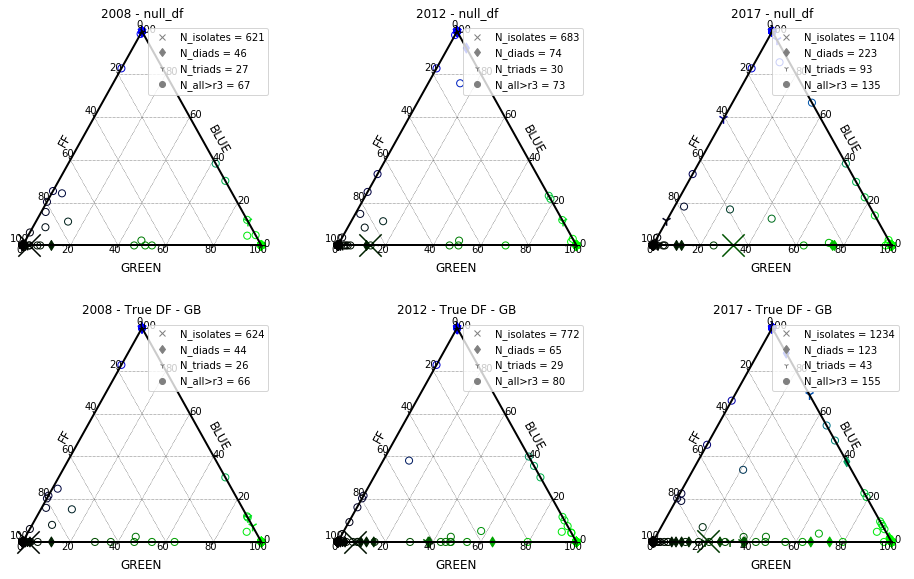

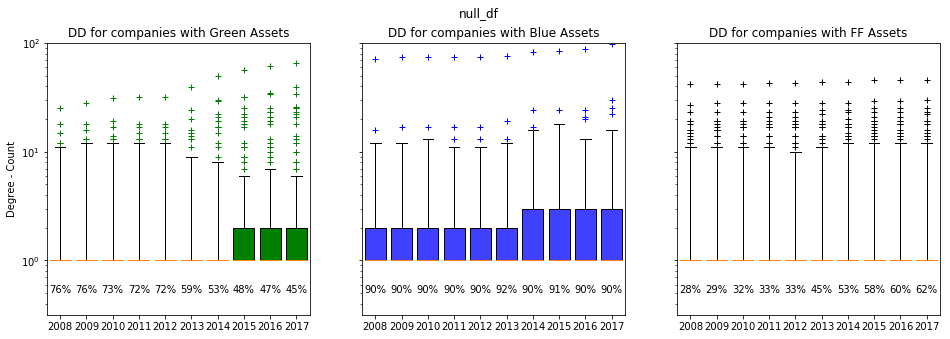

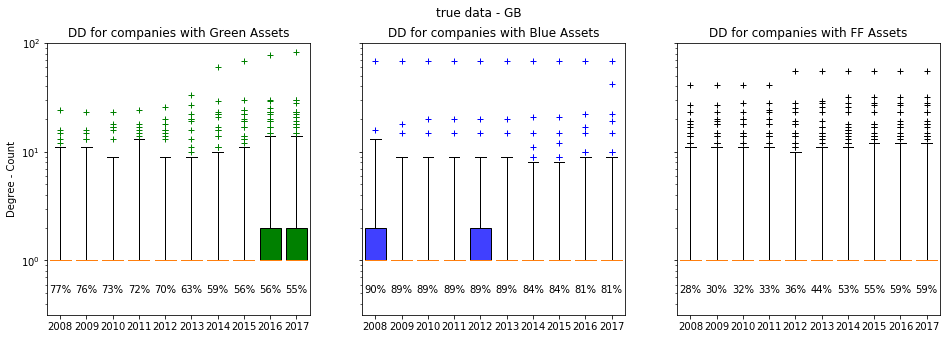

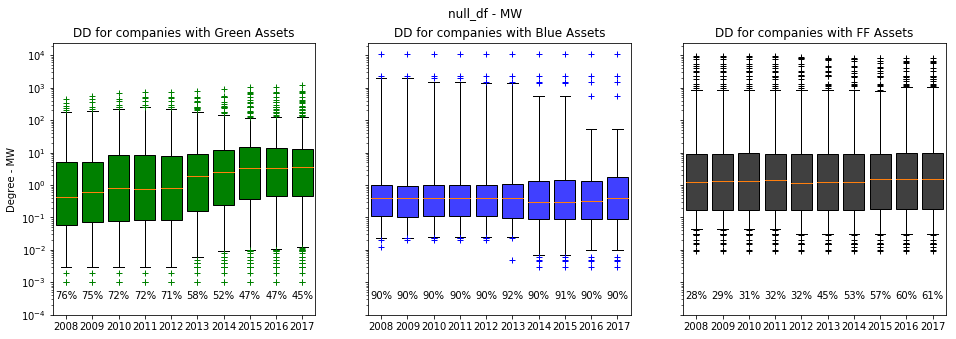

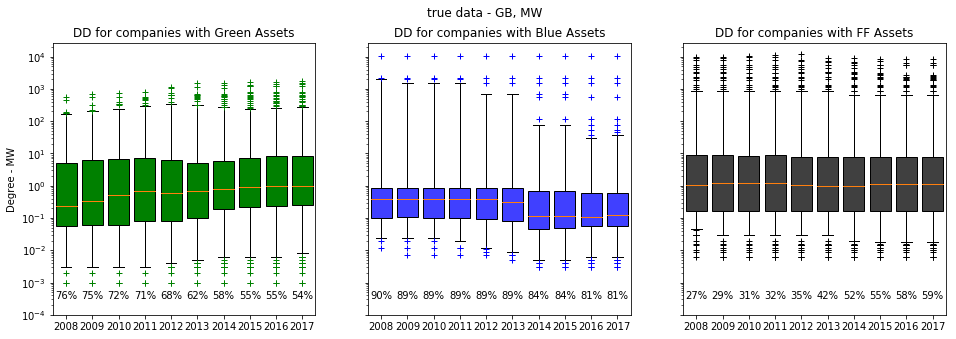

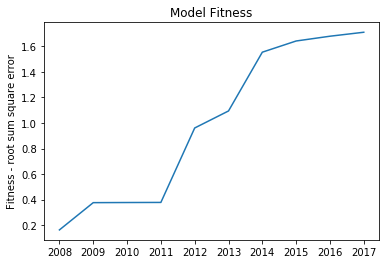

In [21]:
#### show some graphics for the null model stuff
plot_ternary([null_df, iso_slice_plants],['null_df','True DF - GB'])
plot_DD_boxplot(null_df, 'null_df', years, MW = False)
plot_DD_boxplot(iso_slice_plants, 'true data - GB', years, MW = False)
plot_DD_boxplot(null_df, 'null_df - MW', years, MW = True)
plot_DD_boxplot(iso_slice_plants, 'true data - GB, MW', years, MW = True)
stats_T = get_stats(iso_slice_plants,years)
stats_N = get_stats(null_df, years)
plot_fitness(stats_T, stats_N,years)

## 6. Company Clusters and Transitions

<div style="text-align: justify">Across many countries and network arrangements, how might a bipartite network of assets and companies be abstracted for further analysis? The asset projection of the asset-company bipartite network forms only fully connected components of various sizes, due to each asset having only one edge to a single company. Many conventional network properties used commonly for network abstraction and analysis  (e.g. centrality, betweenness, path lengths, components) are innappropriate for this sort of abstraction. </div><br>

<div style="text-align: justify">Clusters of like-components may easier allow the abstraction of the network arrangement and analysis over time and with external data. Because each component represents a company, the analogues to mechanisms from the innovation and diffusion literature are also more illustrative. This section develops the clustering method for the components of a single country's power sector network.</div>

### 6.1 Clustering Criteria

Clusters are ascribed the following twelve attributes:

$B_l\:in\:\begin{Bmatrix} \begin{Bmatrix}{sum_{MW}\\mean_{MW}\\count}\end{Bmatrix}of\begin{Bmatrix}{all\\green\\blue\\ff}\end{Bmatrix} assets \end{Bmatrix}$

### 6.2 Company  Clustering

<div style="text-align: justify">A k-means clustering algorithm is used to group the fully connected components (i.e. companies). The inclusion of the count of assets and the mean of asset size by fuel class makes full use of the information available in asset-level data. Raw inputs in counts and MW are first converted to z-scores measuring the number of standard deviations of that asset's attributes from the means of the attributes of all assets. The number of clusters is increased until the marginal additional cluster decreases cluster error by less than 10%. The number of clusters required per year for a given error reduction threshold is shown in Fig Ref. Clusters are drawn for a select year in Fig Ref.</div>

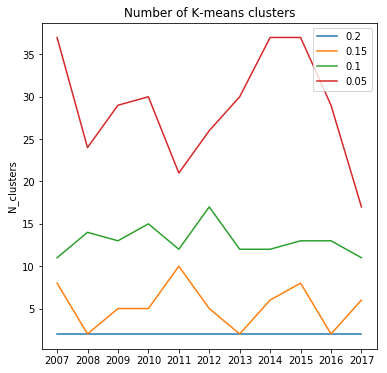

In [16]:
plot_n_clusters(iso_slice_plants, years, [0.2,0.15,0.1,0.05])

In [11]:
cluster_stats, cluster_dfs = get_clusters(iso_slice_plants,years,0.1)

     tot_MW  green_MW   blue_MW     ff_MW  green_count  blue_count  ff_count  \
0  8.978948  3.184052  0.188666  5.606229     0.592695    0.238456  0.499655   

   green_avg  blue_avg    ff_avg   tot_avg  tot_count   COUNT  
0   1.880219  0.100988  3.330129  5.311336   1.330806  1451.0  


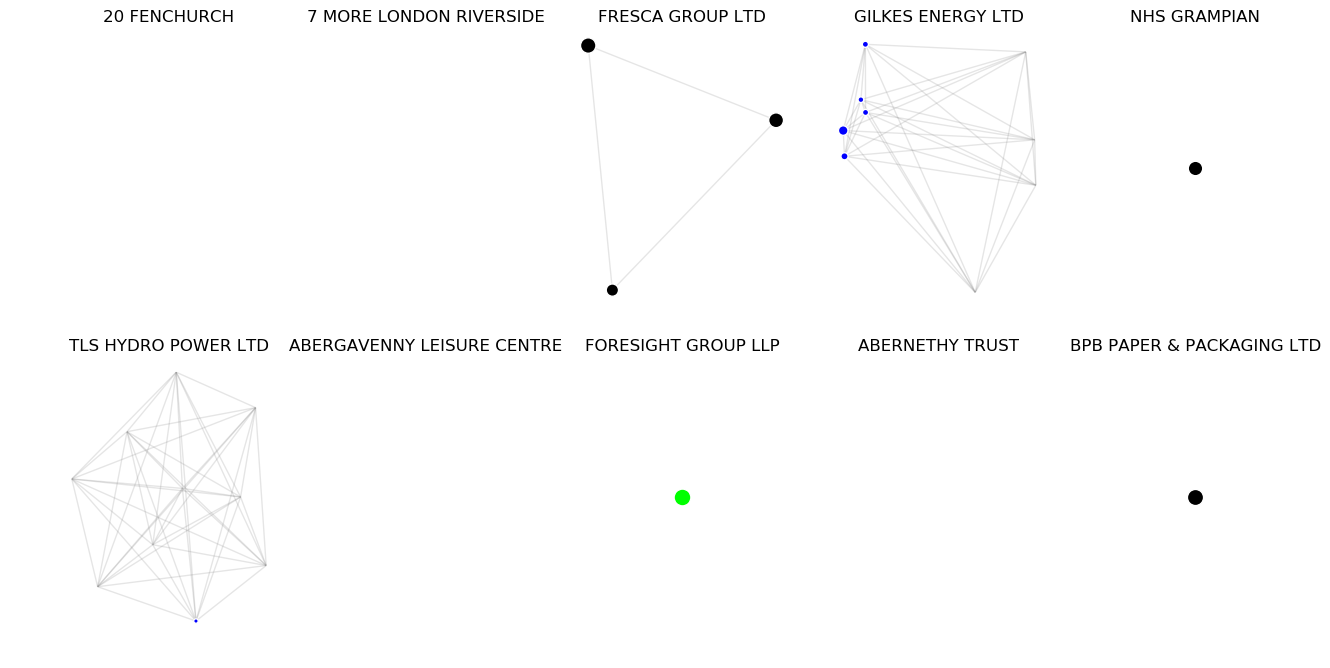

       tot_MW   green_MW    blue_MW      ff_MW  green_count  blue_count  \
1  183.040544  135.68393  12.689772  34.666842     8.912281    1.912281   

   ff_count  green_avg  blue_avg    ff_avg   tot_avg  tot_count  COUNT  
1  0.298246  35.907985  0.958693  2.652072  39.51875  11.122807   57.0  


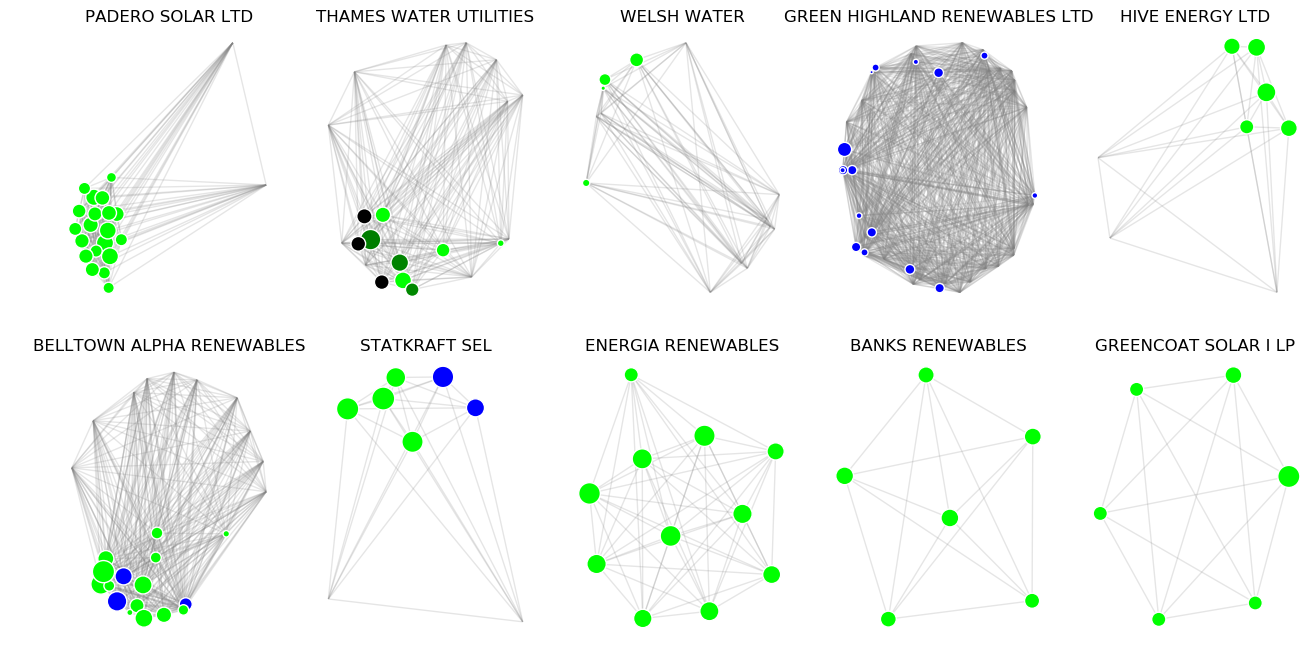

       tot_MW  green_MW  blue_MW      ff_MW  green_count  blue_count  \
2  104.707682  5.279864      0.0  99.427818     0.727273         0.0   

    ff_count  green_avg  blue_avg    ff_avg   tot_avg  tot_count  COUNT  
2  15.590909   0.454856       0.0  7.272033  7.726888  16.318182   22.0  


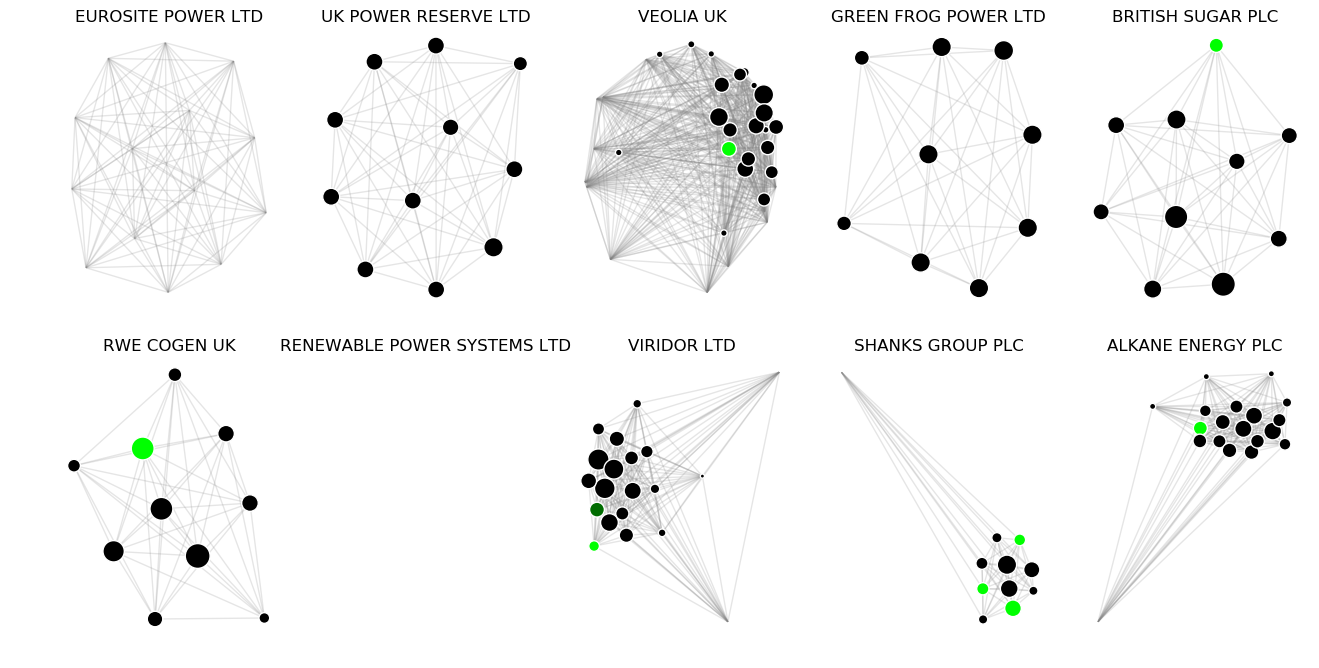

    tot_MW  green_MW  blue_MW    ff_MW  green_count  blue_count  ff_count  \
3  1517.94       0.0      0.0  1517.94          0.0         0.0       1.6   

   green_avg  blue_avg   ff_avg  tot_avg  tot_count  COUNT  
3        0.0       0.0  1045.78  1045.78        1.6   10.0  


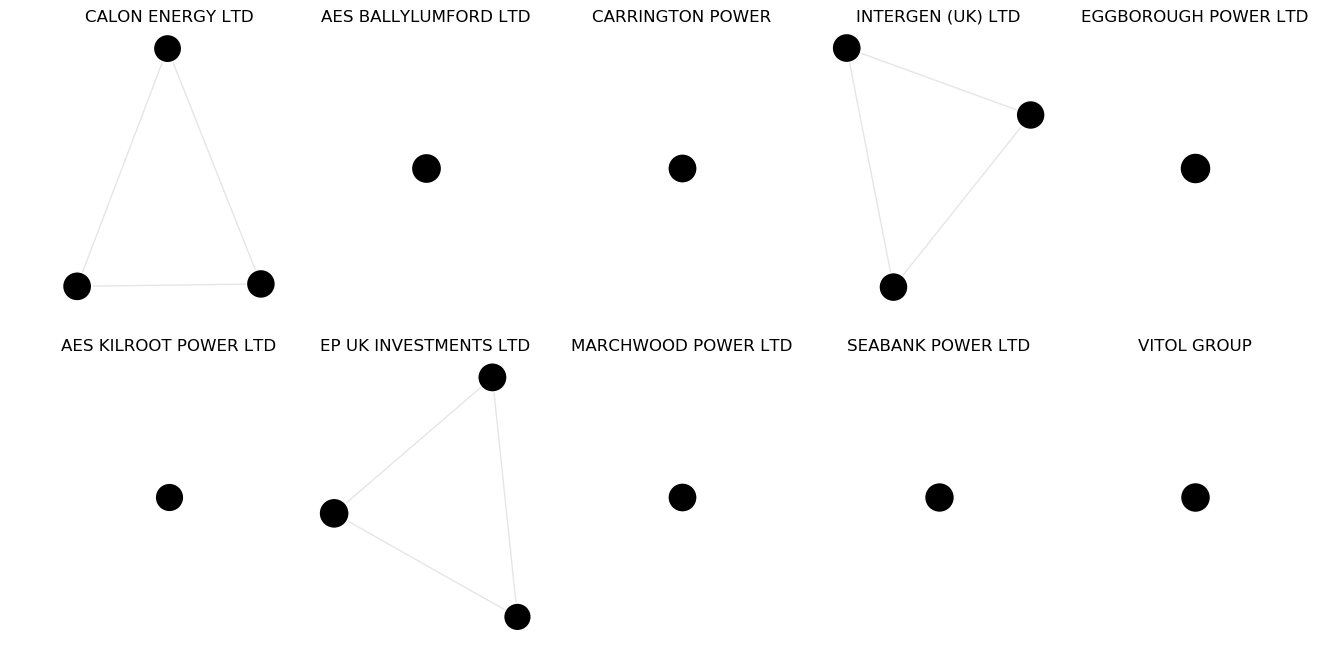

       tot_MW  green_MW   blue_MW  ff_MW  green_count  blue_count  ff_count  \
4  978.917125   969.073  9.844125    0.0         30.5        2.75       0.0   

   green_avg  blue_avg  ff_avg    tot_avg  tot_count  COUNT  
4  66.776528   0.18931     0.0  66.965838      33.25    8.0  


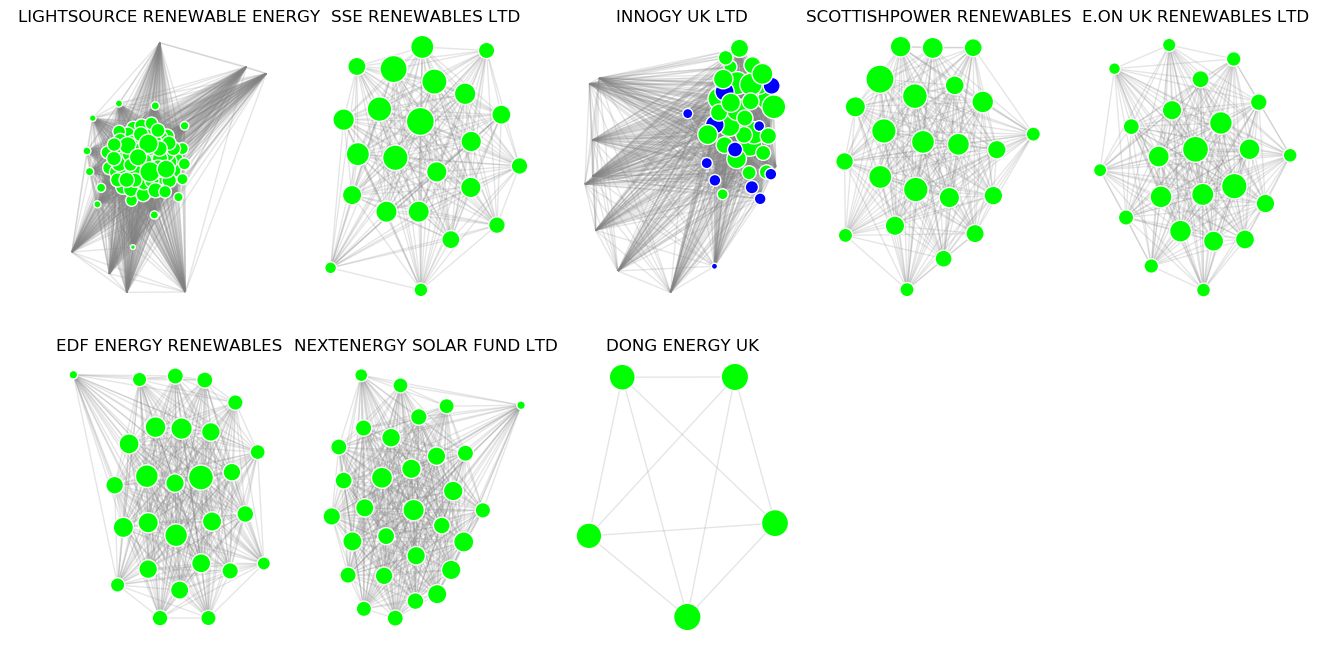

     tot_MW  green_MW  blue_MW     ff_MW  green_count  blue_count  ff_count  \
5  7106.155       0.0      0.0  7106.155          0.0         0.0      10.0   

   green_avg  blue_avg      ff_avg     tot_avg  tot_count  COUNT  
5        0.0       0.0  734.440495  734.440495       10.0    2.0  


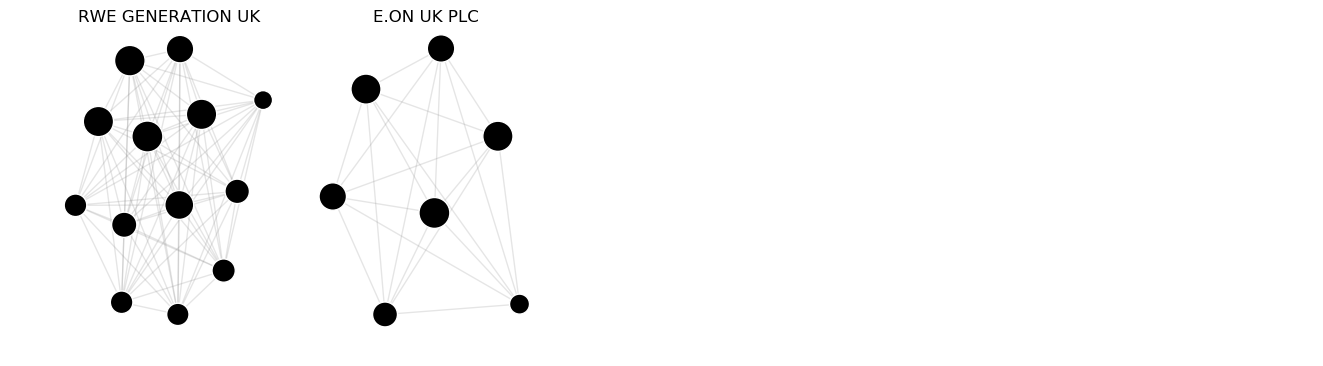

    tot_MW  green_MW  blue_MW   ff_MW  green_count  blue_count  ff_count  \
6  16119.0       0.0  10644.0  5475.0          0.0         8.0       2.0   

   green_avg  blue_avg  ff_avg  tot_avg  tot_count  COUNT  
6        0.0    1064.4   547.5   1611.9       10.0    1.0  


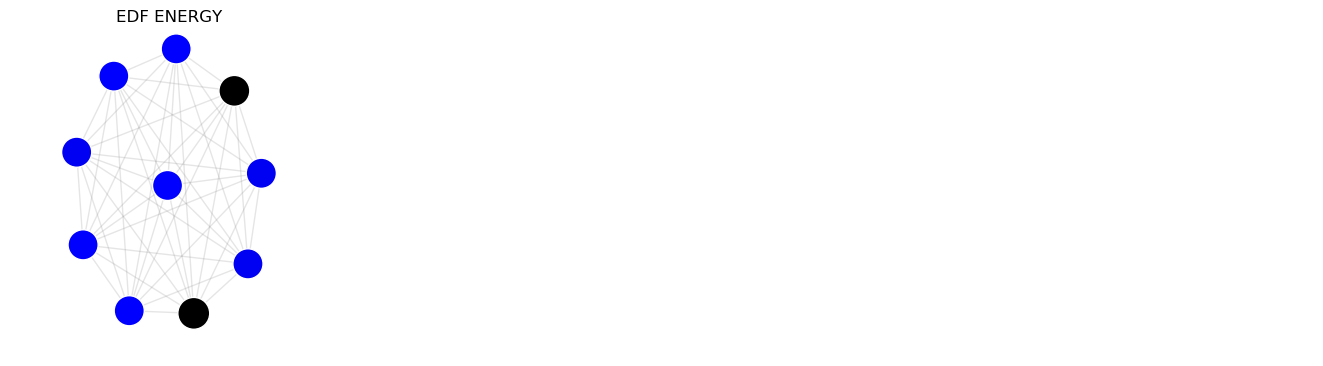

     tot_MW  green_MW   blue_MW    ff_MW  green_count  blue_count  ff_count  \
7  7836.929   180.697  1502.782  6153.45          7.0        68.0      23.0   

   green_avg  blue_avg     ff_avg    tot_avg  tot_count  COUNT  
7   1.843847  15.33451  62.790306  79.968663       98.0    1.0  


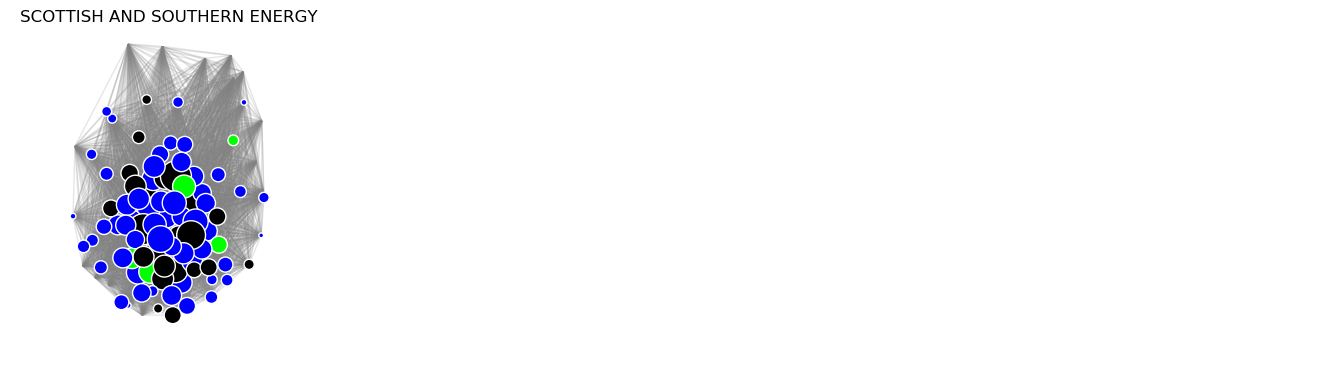

   tot_MW  green_MW  blue_MW   ff_MW  green_count  blue_count  ff_count  \
8  3970.0    1260.0      0.0  2710.0          0.0         0.0       1.0   

   green_avg  blue_avg  ff_avg  tot_avg  tot_count  COUNT  
8     1260.0       0.0  2710.0   3970.0        1.0    1.0  


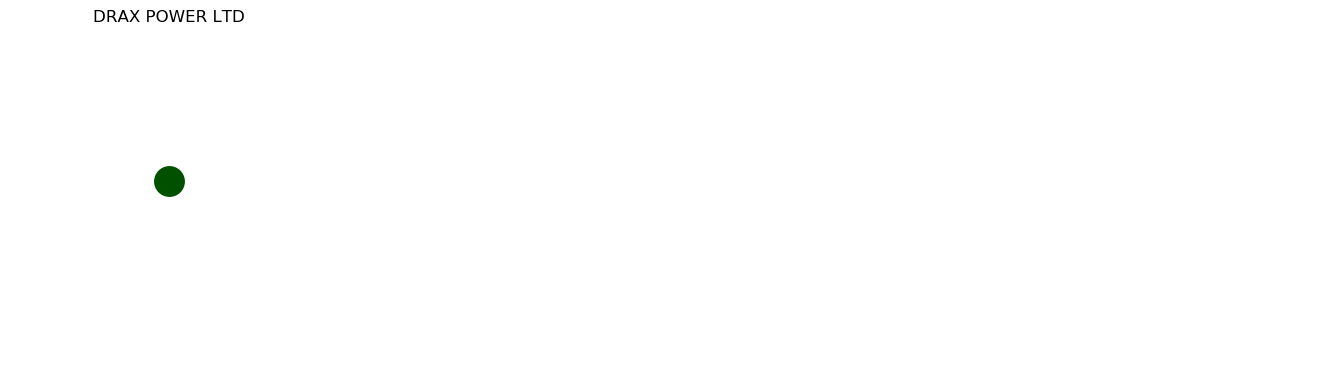

   tot_MW  green_MW  blue_MW  ff_MW  green_count  blue_count  ff_count  \
9  2250.0       0.0   2250.0    0.0          0.0         2.0       0.0   

   green_avg  blue_avg  ff_avg  tot_avg  tot_count  COUNT  
9        0.0    1125.0     0.0   1125.0        2.0    1.0  


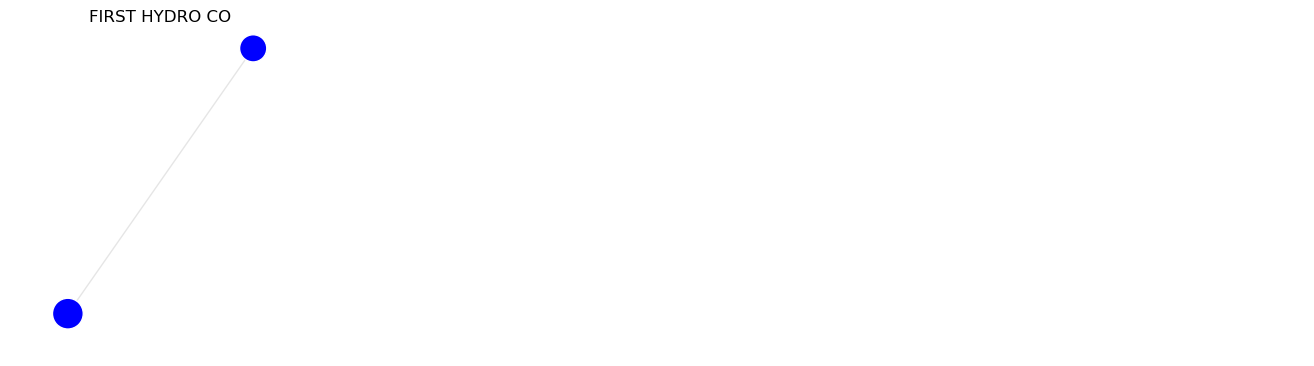

     tot_MW  green_MW  blue_MW    ff_MW  green_count  blue_count  ff_count  \
10  468.957    317.05   18.294  133.613         18.0        15.0      55.0   

    green_avg  blue_avg   ff_avg   tot_avg  tot_count  COUNT  
10   3.602841  0.207886  1.51833  5.329057       88.0    1.0  


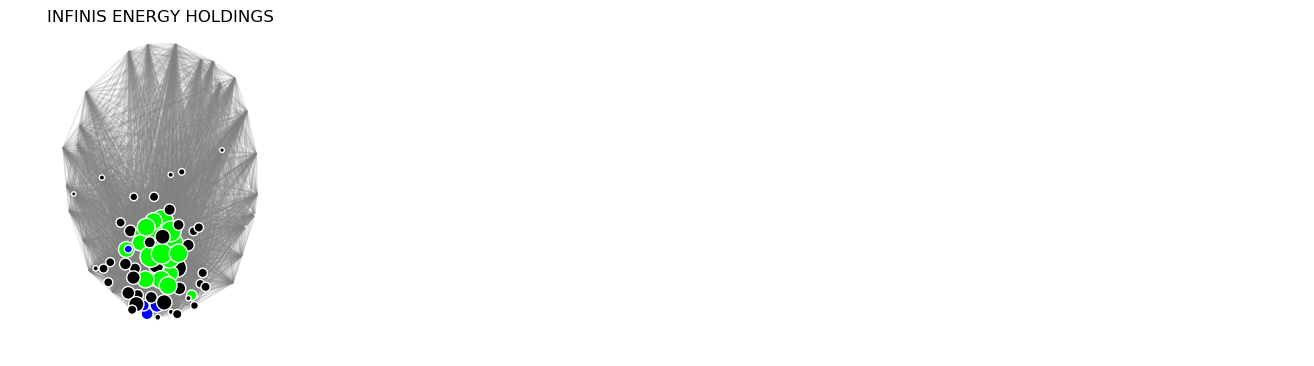

In [12]:
### Draw clusters

select_year = 2017

for c in range(len(cluster_dfs[select_year]['clusters'].unique())):
    print cluster_stats[select_year].ix[c].to_frame().T
    co_list = cluster_dfs[select_year].loc[cluster_dfs[select_year].clusters==c].COMPANY.unique()#[0:1]

    if len(co_list)>10:
        co_list= co_list[:10]
        
    draw_top_companies(iso_slice_plants[select_year],MW=True, N=None, co_list=co_list ) 
plt.show()

### 6.3 Cluster Transitions
<div style="text-align: justify">Clusters are analysed for how they change over time. The use of K-means clustering provides a generalisable method for dimensional reduction of company-asset networks of any configuration without having to describe a heuristical filter other than the company attributes of interest for clustering. This property-agnostic method facilitates progress towards a synthetic model, discussed in the next section. Cluster transitions are shown in Fig Ref.</div><br>

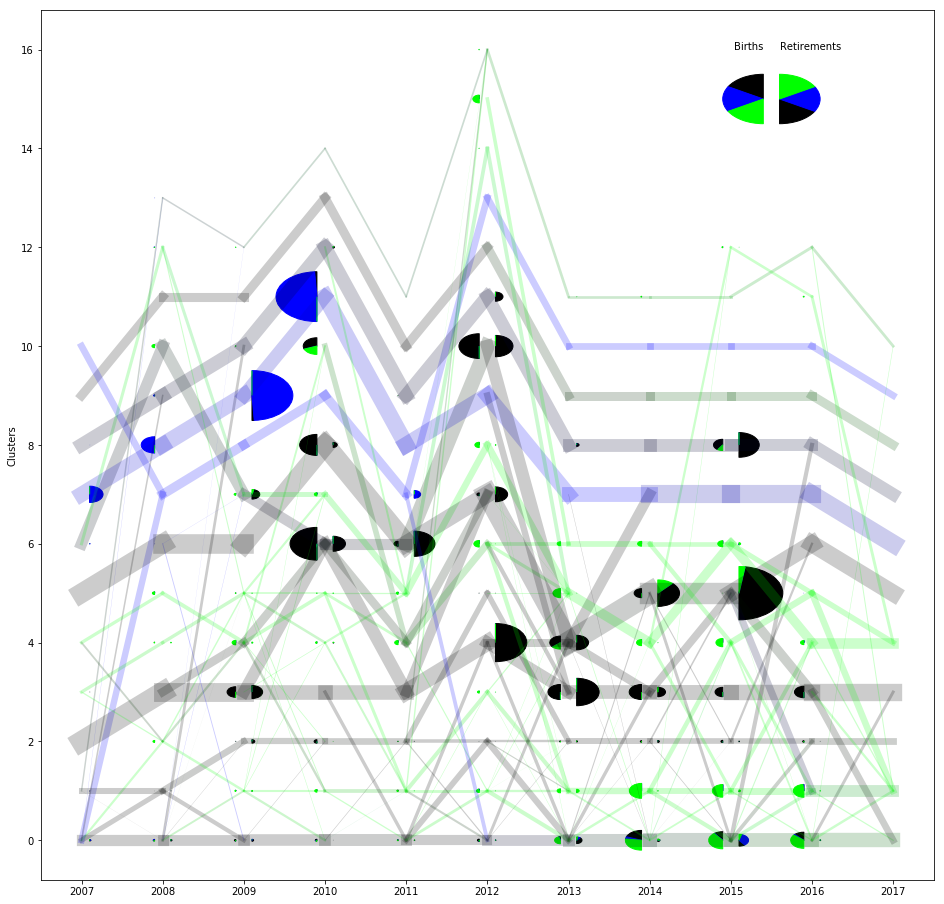

In [13]:
draw_cluster_transitions(cluster_dfs, cluster_stats, years)

## 7. Towards a Synthetic Model

<div style="text-align: justify">The purpose of this study remains to define a model of power sector asset growth which shows prescience in how network arrangements change over time subject to some external stimulae. A synthetic model is described which is more independent of the true data than the null model.</div>

### 7.1 Clusters as Motifs
<div style="text-align: justify">Motif-based analysis of networks is used to reduce network arrangements to manageable abstractions by identifying recurring network patterns. These patterns assist in defining isomorphic networks, reducing computational requirements, and the motifs themselves often have significance in terms of describing the real observed mechanism. Clusters might be used in an analogous fashion in order to reduce the dimensionality of the network arrangement. The entire network arrangement now might be described by a number of centroids in the twelve-dimentional space described by $B_j$. The movement, emergence, and destruction of these centroids might be easier to investigate than changes in the nodes and edges themselves.</div>

### 7.2 Significance of Exogenous Variables
<div style="text-align: justify"> The synthetic model can be posed such that it tests the influence of exogenous variables of interest on transitions within and between the clusters of companies, and on the birth and retirement of assets. This model can then address questions like the efficacy of policy; the embeddedness of innovation; the role of innvation networks at various scales, including within a single company. Exogenous data shown in Table Ref have been collected to address these research questions.</div>

| Exogenous Variable        | Data Source           | 
| :------------- |:-------------:| 
| Renewables Resources (wind + solar)  |  Global wind/solar atlas |
| Environmental Porformance Index |  WEF  |
| Renewables Policy Indicators (~10) | Ren21 Global Status Reports      |
| Country Network - Shared land boarder      | Natural Earth | 
| Country Network - Shared Langauge    | Wikipedia      | 
| Country Network - Trade (wind generators, solar PV, electircal energy, all goods, services | UN Comtrade Data  | 


<div style="text-align: justify"> Introducing these exogenous variables still introduces causality and simultaneity challenges in the model. </div>



In [90]:
print pd.read_csv('policy_df.csv').head(20)

      country iso2 iso3  PV_MEAN  WIND_MEAN  2007_FIT  2007_RPS  \
0     Algeria   DZ  DZA    5.601   5.110283       1.0       0.0   
1     Austria   AT  AUT    3.876   6.245603       1.0       0.0   
2      Canada   CA  CAN    4.312   6.047930       0.5       0.5   
3       China   CN  CHN    7.682   5.900064       1.0       0.0   
4      Cyprus   CY  CYP    4.832   5.037345       1.0       0.0   
5     Denmark   DK  DNK    3.041   7.414727       1.0       0.0   
6     Ecuador   EC  ECU    4.898   3.321832       1.0       0.0   
7     Estonia   EE  EST    3.017   6.229922       1.0       0.0   
8      France   FR  FRA    5.095   5.512532       1.0       0.0   
9     Germany   DE  DEU    3.457   6.255210       1.0       0.0   
10     Greece   GR  GRC    4.758   4.019278       1.0       0.0   
11    Hungary   HU  HUN    3.433   5.132396       1.0       0.0   
12      India   IN  IND    6.015   4.251691       0.5       0.5   
13  Indonesia   ID  IDN    4.835   1.585141       1.0       0.

**Fig: Geographic Adjacency Network **
<img src="files/figures/country_layer/geographic.png">

**Fig: Language Adjacency Network **
<img src="files/figures/country_layer/language.png">

**Fig: Language Adjacency Spring Layout Network ** 

<font color='red'>English;</font> <font color='blue'>French </font> <font color='purple'> Arabic</font> <font color='yellow'>Spanish</font> <font color='orange'>Portuguese</font> <font color='green'>German</font> Other
<img src="files/figures/country_layer/language_spring.png">

**Fig: Trade Network **
<img src="files/figures/country_layer/850231.gif">
<img src="files/figures/country_layer/845150.gif">
<img src="files/figures/country_layer/845140.gif">
<img src="files/figures/country_layer/271600.gif">
**Also available:** Global trade of all goods and services (but computationally expensive to generate figures)



### 7.3 Model Description
<div style="text-align: justify"> With company clusters and exogenous data a full synthetic model can be prepared which tests mechanisms for network growth and the attachment (and re-attachment) of assets to companies. The significance of expogenous variables is compared also to network architectures, separating exogenous and network effects.</div>


**Table: Synthetic Model Mechanisms**

| Mechanism | Null Model |
|   :------   |   -------:   | 
| Node Attribute: Fuel class Pr[g,b,f] | $F(clusters, t, \epsilon, exogenous\:vars)$ |
| Node Attribute: Size(MW) | $F(clusters, t, \epsilon, exogenous\:vars)$ |
| Edge formation at birth | Preferential attachment minimizing euclidean distance |
| Node birth rate | taken from true data |
| Node death rate| $F(clusters, t, \epsilon, exogenous\:vars)$ |
| Edge switching| $F(clusters, t, \epsilon, exogenous\:vars)$(?) |